# Compute viable habitat in geographic space

Viable habitat is computed as the convolution of trait space with environmental conditions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from itertools import product

import data_collections as dc
import funnel
import intake
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import operators as ops
import util
import xarray as xr
import yaml

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_active
trait_spc_wgt

<xarray.DataArray 'trait_spc_active' (Ac: 12, Eo: 11)>
array([[1.00358230e-04, 6.72698399e-04, 2.81408643e-03, 7.33609608e-03,
        1.19297474e-02, 1.27449962e-02, 1.20953656e-02, 7.64600251e-03,
        3.01496564e-03, 7.40878515e-04, 1.13620084e-04],
       [2.15385464e-04, 1.44372273e-03, 6.03949784e-03, 1.57444832e-02,
        2.56032234e-02, 2.73528831e-02, 2.59586678e-02, 1.64095940e-02,
        6.47061807e-03, 1.59004860e-03, 2.43847612e-04],
       [2.90987855e-04, 1.95048344e-03, 8.15942028e-03, 2.12709498e-02,
        3.45902036e-02, 3.69540110e-02, 3.50704125e-02, 2.21695209e-02,
        8.74186790e-03, 2.14817112e-03, 3.29440494e-04],
       [3.03348682e-04, 2.03333771e-03, 8.50602299e-03, 2.21745151e-02,
        3.60595553e-02, 3.85237745e-02, 3.65601629e-02, 2.31112565e-02,
        9.11321231e-03, 2.23942293e-03, 3.43434744e-04],
       [2.65211673e-04, 1.77770641e-03, 7.43664545e-03, 1.93867342e-02,
        3.15261466e-02, 3.36805640e-02, 3.19638178e-02, 2.02057084e-02,
        7.96749890e-03, 1.95788259e-03, 3.00258114e-04],
       [2.02910265e-04, 1.36010182e-03, 5.68968808e-03, 1.48325574e-02,
        2.41202760e-02, 2.57685949e-02, 2.44551330e-02, 1.54591447e-02,
        6.09583768e-03, 1.49795245e-03, 2.29723876e-04],
       [1.38808801e-04, 9.30431502e-04, 3.89225641e-03, 1.01467982e-02,
        1.65004298e-02, 1.76280276e-02, 1.67295020e-02, 1.05754401e-02,
        4.17009913e-03, 1.02473368e-03, 1.57151713e-04],
       [8.60027226e-05, 5.76473839e-04, 2.41155205e-03, 6.28672147e-03,
        1.02232847e-02, 1.09219182e-02, 1.03652125e-02, 6.55229806e-03,
        2.58369697e-03, 6.34901290e-04, 9.73675666e-05],
       [4.88294430e-05, 3.27302387e-04, 1.36919786e-03, 3.56938825e-03,
        5.80443598e-03, 6.20109650e-03, 5.88501779e-03, 3.72017367e-03,
        1.46693593e-03, 3.60475522e-04, 5.52820178e-05],
       [2.54539295e-05, 1.70616976e-04, 7.13738753e-04, 1.86065930e-03,
        3.02575035e-03, 3.23252251e-03, 3.06775624e-03, 1.93926109e-03,
        7.64687892e-04, 1.87909548e-04, 2.88175433e-05],
       [1.22509648e-05, 8.21178736e-05, 3.43522140e-04, 8.95534480e-04,
        1.45629228e-03, 1.55581163e-03, 1.47650969e-03, 9.33365485e-04,
        3.68043938e-04, 9.04407805e-05, 1.38698706e-05],
       [5.43994403e-06, 3.64637924e-05, 1.52538289e-04, 3.97655003e-04,
        6.46655070e-04, 6.90845848e-04, 6.55632452e-04, 4.14453562e-04,
        1.63427000e-04, 4.01595133e-05, 6.15880634e-06]])
Coordinates:
  * Ac       (Ac) float64 0.03 0.037 0.0456 0.0562 ... 0.1601 0.1974 0.2433 0.3
  * Eo       (Eo) float64 -0.5 -0.3056 -0.1111 0.0833 ... 0.8611 1.056 1.25
Attributes:
    N_traits:            132
    long_name:           Trait density (active)
    metabolic_baseline:  active
    units:               eV 1/kPa

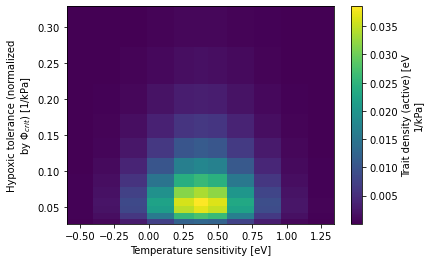

In [4]:
trait_spc_wgt.plot();

In [5]:
dEodT_bar = mi.dEodT_bar
dEodT_bar

0.022

In [6]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,32
variable,8
name,1
path,406


In [7]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [20]:
clusted_scale = 10  # if calc needs to be redone, set to 200
if clusted_scale:
    try:
        cluster
        client
    except:
        cluster, client = util.get_ClusterClient(memory='64GB')
        cluster.scale(clusted_scale)
client

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46300 instead
  f"Port {expected} is already in use.\n"


In [21]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [22]:
clobber = False

stream = "pop.h"
component = "ocn"

phi_upper_bound = 2

variable = "depth_habitat_trait_wgt"

for experiment, member_id in product(experiment_list, member_id_list):

    # check for existing cache file
    asset = dc.fnl_gen_cache_file_name(
        experiment, component, stream, member_id, variable, "drift-corrected"
    )

    if clobber and os.path.exists(asset):
        print(f"removing: {asset}")
        shutil.rmtree(asset)

    if os.path.exists(asset):
        print(f"exists: {asset}")
        continue

    with util.timer(f"{experiment}.{member_id}"):

        cat = catalog.search(
            experiment=experiment,
            member_id=member_id,
            stream=stream,
            component=component,
            variable=["TEMP", "pO2"],
        )

        # ensure variables
        missing_vars = {"TEMP", "pO2"} - set(cat.df.variable.to_list())
        if missing_vars:
            print(f"missing vars for {experiment}.{member_id:03d}: {missing_vars}")
            continue

        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1
        _, ds = dset.popitem()

        # compute
        print(f"computing: {asset}")

        # compute trait-density weighted sum of viable habitat over depth
        var_out = xr.full_like(ds.TEMP[:, 0, :, :], fill_value=0.0)
        dso = ds[["TAREA", "TLONG", "TLAT", "KMT", "z_t", "dz", "time_bound"]]
        for Eo, Ac in product(trait_spc_wgt.Eo.values, trait_spc_wgt.Ac.values):
            # get the trait weighting for this trait
            trait_wgt_ij = trait_spc_wgt.sel(Eo=Eo, Ac=Ac).values

            # compute the metabolic index
            Phi = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)

            # compute the vertical integral of habitat volume where Φ > 1
            # multiplied by trait space weighting
            viable_trait_mask = xr.where(
                (1 < Phi) & (Phi <= phi_upper_bound),
                trait_wgt_ij,
                0.0,
            )

            # add this "viable depth" to total depth
            var_out += (ds.dz * viable_trait_mask).sum("z_t")

        print(f"writing: {asset}")
        var_out.name = variable
        var_out.attrs["long_name"] = "Trait-space weighted vertical habitat"
        var_out.attrs["units"] = " ".join([ds.z_t.attrs["units"], trait_spc_wgt.attrs["units"]])
        dso[variable] = var_out
        dso.to_zarr(asset, mode="w", consolidated=True)
        dc.fnl_make_cache(experiment, component, stream, member_id, variable, "drift-corrected")

exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocea

In [23]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=member_id_list,
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,32
variable,8
name,1
path,406


In [24]:
def fix_dataset(ds):
    ds['depth_habitat_trait_wgt'] = ds.depth_habitat_trait_wgt.where(ds.KMT > 0)
    return ds.set_coords(['TLAT', 'TLONG'])


cat = catalog.search(variable='depth_habitat_trait_wgt')
dsets = cat.to_dataset_dict(preprocess=fix_dataset, zarr_kwargs={'use_cftime': True})
dsets = {k: ds for k, ds in dsets.items()}


exp_keys = ['20C.ocn.pop.h.drift-corrected', 'RCP85.ocn.pop.h.drift-corrected']
ds = xr.concat([dsets[k] for k in exp_keys], dim='time', coords='minimal', compat='override')
ds = ds.reset_coords(['ULAT', 'ULONG'], drop=True)
ds['TLAT'] = ds.TLAT[0, :, :]
ds['TLONG'] = ds.TLONG[0, :, :]
ds = ds.set_coords(['TLAT', 'TLONG'])
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:                  (nlat: 384, nlon: 320, member_id: 32, time: 2172, z_t: 40)
Coordinates:
    KMT                      (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TAREA                    (nlat, nlon) float64 1.125e+13 ... 7.432e+12
    TLAT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                       (z_t) float32 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * time                     (time) object 1920-01-17 00:29:59.999993 ... 210...
  * z_t                      (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
  * member_id                (member_id) int64 2 9 10 11 12 ... 102 103 104 105
Dimensions without coordinates: nlat, nlon
Data variables:
    depth_habitat_trait_wgt  (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 12, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    nco_openmp_thread_number:  1
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nsteps_total:              750
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    calendar:                  All years have exactly  365 days.
    NCO:                       4.3.4
    ...                        ...
    contents:                  Diagnostic and Prognostic Variables
    tavg_sum_qflux:            2592000.0
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    tavg_sum:                  2592000.0
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

In [25]:
ds.depth_habitat_trait_wgt

<xarray.DataArray 'depth_habitat_trait_wgt' (member_id: 32, time: 2172, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(32, 2172, 384, 320), dtype=float64, chunksize=(1, 12, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 1920-01-17 00:29:59.999993 ... 2100-12-16 12:00:00
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Trait-space weighted vertical habitat
    note:          corrected for drift in control integration
    units:         centimeters eV 1/kPa

In [26]:
nyr = int(ds.sizes['time'] / 12)

dpm = xr.DataArray(
    np.tile([31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0], nyr),
    dims=("time"),
    coords={'time': ds.time},
)
time_weights = dpm.groupby('time.year') / dpm.groupby('time.year').sum()
np.testing.assert_allclose(time_weights.groupby('time.year').sum().values, np.ones(nyr))

In [32]:
%%time
ds_ann = ops.resample_ann(ds, time_weights)
ds_ann

CPU times: user 1.1 s, sys: 4.95 ms, total: 1.1 s
Wall time: 2.26 s


<xarray.Dataset>
Dimensions:                  (nlat: 384, nlon: 320, z_t: 40, member_id: 32, time: 181)
Coordinates:
    TLAT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                       (z_t) float32 1e+03 1e+03 ... 9.844e+03 1.133e+04
    TLONG                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT                      (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * z_t                      (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
  * member_id                (member_id) int64 2 9 10 11 12 ... 102 103 104 105
    TAREA                    (nlat, nlon) float64 1.125e+13 ... 7.432e+12
  * time                     (time) int64 1920 1921 1922 1923 ... 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    depth_habitat_trait_wgt  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    nco_openmp_thread_number:  1
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nsteps_total:              750
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    calendar:                  All years have exactly  365 days.
    NCO:                       4.3.4
    ...                        ...
    contents:                  Diagnostic and Prognostic Variables
    tavg_sum_qflux:            2592000.0
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    tavg_sum:                  2592000.0
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

In [57]:
%%time
with xr.set_options(keep_attrs=True):
    aero_hab_glb = (ds_ann.depth_habitat_trait_wgt * ds_ann.TAREA).sum(['nlat', 'nlon']).compute()
    aero_hab_glb *= 1e-6 * 1e-6 * 1e-9
    aero_hab_glb.attrs['units'] = '10$^6$ km$^3$'
    aero_hab_glb.attrs['long_name'] = 'Trait-space weighted aerobic habitat'

    aero_hab_glb_control = aero_hab_glb.sel(time=slice(1920, 1965)).mean(['time', 'member_id'])
    aero_hab_glb_normalized = (
        100.0 * (aero_hab_glb - aero_hab_glb_control) / aero_hab_glb_control
    ).compute()
    aero_hab_glb_normalized.attrs['units'] = '%'

aero_hab_glb

CPU times: user 1min 3s, sys: 1.19 s, total: 1min 4s
Wall time: 2min 46s


<xarray.DataArray (time: 181, member_id: 32)>
array([[86.57505977, 86.5762758 , 86.55627938, ..., 86.55331157,
        86.53355974, 86.56484162],
       [86.56462603, 86.51923832, 86.4739014 , ..., 86.51147695,
        86.42126943, 86.50466917],
       [86.54360091, 86.50854386, 86.37564421, ..., 86.48277488,
        86.45280683, 86.44491076],
       ...,
       [78.90426442, 79.02330486, 78.9325915 , ..., 78.67696811,
        78.84823667, 78.72561131],
       [78.77152449, 78.84784579, 78.8064818 , ..., 78.62183304,
        78.79575804, 78.65863788],
       [78.67106704, 78.69578052, 78.69497836, ..., 78.47723841,
        78.70224245, 78.58013495]])
Coordinates:
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Trait-space weighted aerobic habitat
    note:          corrected for drift in control integration
    units:         10$^6$ km$^3$

In [56]:
aero_hab_glb

<xarray.DataArray (time: 181, member_id: 32)>
array([[86.57505977, 86.5762758 , 86.55627938, ..., 86.55331157,
        86.53355974, 86.56484162],
       [86.56462603, 86.51923832, 86.4739014 , ..., 86.51147695,
        86.42126943, 86.50466917],
       [86.54360091, 86.50854386, 86.37564421, ..., 86.48277488,
        86.45280683, 86.44491076],
       ...,
       [78.90426442, 79.02330486, 78.9325915 , ..., 78.67696811,
        78.84823667, 78.72561131],
       [78.77152449, 78.84784579, 78.8064818 , ..., 78.62183304,
        78.79575804, 78.65863788],
       [78.67106704, 78.69578052, 78.69497836, ..., 78.47723841,
        78.70224245, 78.58013495]])
Coordinates:
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Trait-space weighted aerobic habitat
    note:          corrected for drift in control integration
    units:         10$^6$ km$^3$

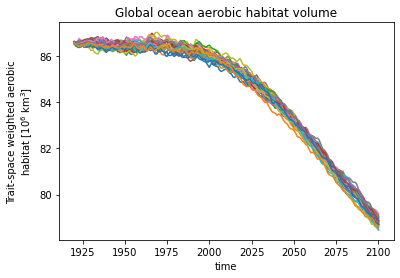

In [34]:
fig, ax = plt.subplots()

for member_id in aero_hab_glb.member_id.values:
    if (aero_hab_glb.sel(member_id=member_id) == 0).all():
        print(member_id)
    aero_hab_glb.sel(member_id=member_id).plot(ax=ax)

ax.set_title('Global ocean aerobic habitat volume');

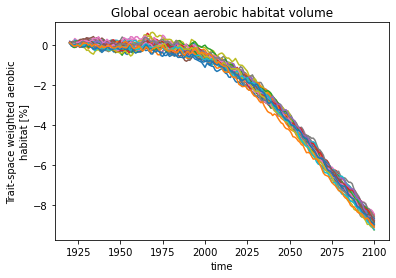

In [61]:
fig, ax = plt.subplots()

for member_id in aero_hab_glb.member_id.values:
    if (aero_hab_glb.sel(member_id=member_id) == 0).all():
        print(member_id)
    aero_hab_glb_normalized.sel(member_id=member_id).plot(ax=ax)

ax.set_title('Global ocean aerobic habitat volume');

In [35]:
epoch = xr.DataArray(['ref_climate', '2100_climate'], dims=('epoch'))
with xr.set_options(keep_attrs=True):
    ds_eph = xr.concat(
        [
            ds_ann.sel(time=slice(1920, 1965)).mean(['member_id', 'time']),
            ds_ann.sel(time=slice(2080, 2100)).mean(['member_id', 'time']),
        ],
        dim=epoch,
        coords='minimal',
    )
ds_eph = ds_eph.where(ds_eph.KMT > 0)
ds_eph

<xarray.Dataset>
Dimensions:                  (epoch: 2, nlat: 384, nlon: 320, z_t: 40)
Coordinates:
    TLAT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                       (z_t) float32 1e+03 1e+03 ... 9.844e+03 1.133e+04
    TLONG                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT                      (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * z_t                      (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
    TAREA                    (nlat, nlon) float64 1.125e+13 ... 7.432e+12
  * epoch                    (epoch) <U12 'ref_climate' '2100_climate'
Dimensions without coordinates: nlat, nlon
Data variables:
    depth_habitat_trait_wgt  (epoch, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    nco_openmp_thread_number:  1
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nsteps_total:              750
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    calendar:                  All years have exactly  365 days.
    NCO:                       4.3.4
    ...                        ...
    contents:                  Diagnostic and Prognostic Variables
    tavg_sum_qflux:            2592000.0
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    tavg_sum:                  2592000.0
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

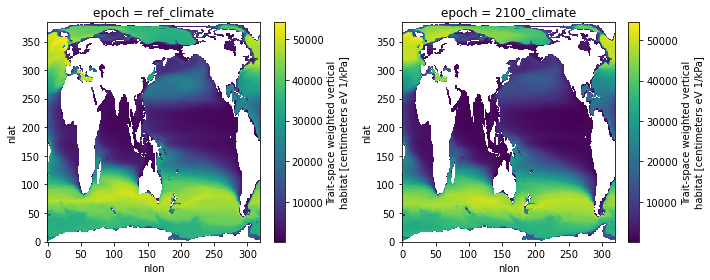

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ds_eph.depth_habitat_trait_wgt.sel(epoch='ref_climate').plot(ax=axs[0])
ds_eph.depth_habitat_trait_wgt.sel(epoch='2100_climate').plot(ax=axs[1])

plt.tight_layout();

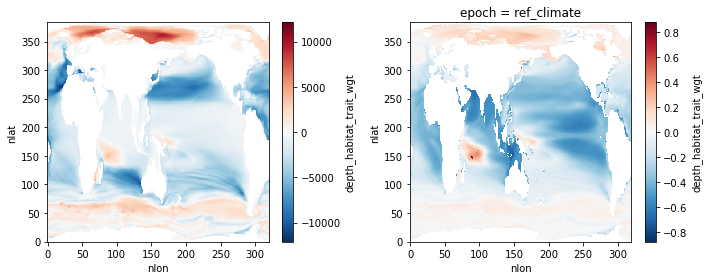

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


(
    ds_eph.depth_habitat_trait_wgt.sel(epoch="2100_climate")
    - ds_eph.depth_habitat_trait_wgt.sel(epoch="ref_climate")
).plot(ax=axs[0])
axs[0].set_title('Absolute habitat change')

(
    (
        ds_eph.depth_habitat_trait_wgt.sel(epoch="2100_climate")
        - ds_eph.depth_habitat_trait_wgt.sel(epoch="ref_climate")
    )
    / ds_eph.depth_habitat_trait_wgt.sel(epoch="ref_climate")
).plot(ax=axs[1])
axs[1].set_title('Relative habitat change')

plt.tight_layout()

In [37]:
habitat_change = (
    (
        ds_eph.depth_habitat_trait_wgt.sel(epoch='2100_climate')
        - ds_eph.depth_habitat_trait_wgt.sel(epoch='ref_climate')
    )
    / ds_eph.depth_habitat_trait_wgt.sel(epoch='ref_climate')
).compute()
habitat_change *= 100.0
habitat_change.attrs['long_name'] = 'Habitat change'
habitat_change.attrs['units'] = '%'
habitat_change.name = 'habitat_change'

habitat_change

<xarray.DataArray 'habitat_change' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.58644597, 0.5508691 , 0.51193234, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    epoch    <U12 'ref_climate'
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Habitat change
    units:      %

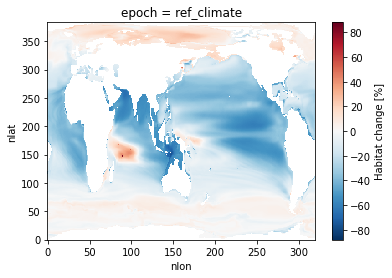

In [38]:
habitat_change.plot();

In [39]:
with xr.set_options(keep_attrs=True):
    ds_var = xr.concat(
        [
            ds.sel(time=slice('1920', '1965')).std(['member_id', 'time']),
            ds.sel(time=slice('2080', '2100')).std(['member_id', 'time']),
        ],
        dim=epoch,
        coords='minimal',
    )
ds_var

<xarray.Dataset>
Dimensions:                  (nlat: 384, nlon: 320, epoch: 2, z_t: 40)
Coordinates:
    KMT                      (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TAREA                    (nlat, nlon) float64 1.125e+13 ... 7.432e+12
    TLAT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                       (z_t) float32 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * z_t                      (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
  * epoch                    (epoch) <U12 'ref_climate' '2100_climate'
Dimensions without coordinates: nlat, nlon
Data variables:
    depth_habitat_trait_wgt  (epoch, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    nco_openmp_thread_number:  1
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nsteps_total:              750
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    calendar:                  All years have exactly  365 days.
    NCO:                       4.3.4
    ...                        ...
    contents:                  Diagnostic and Prognostic Variables
    tavg_sum_qflux:            2592000.0
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    tavg_sum:                  2592000.0
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

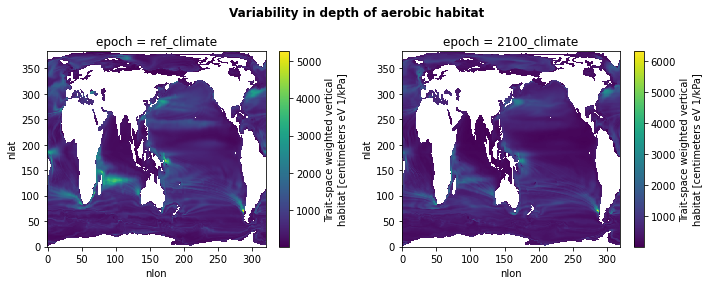

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ds_var.depth_habitat_trait_wgt.sel(epoch='ref_climate').plot(ax=axs[0])
ds_var.depth_habitat_trait_wgt.sel(epoch='2100_climate').plot(ax=axs[1])

plt.suptitle('Variability in depth of aerobic habitat', fontweight='bold')
plt.tight_layout();

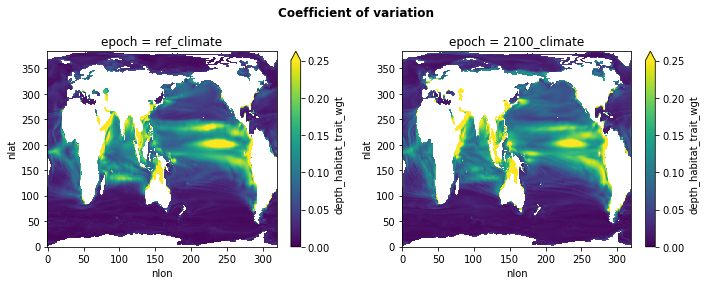

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

(
    ds_var.depth_habitat_trait_wgt.sel(epoch="ref_climate")
    / ds_eph.depth_habitat_trait_wgt.sel(epoch="ref_climate")
).plot(ax=axs[0], vmin=0.0, vmax=0.25)
(
    ds_var.depth_habitat_trait_wgt.sel(epoch="2100_climate")
    / ds_eph.depth_habitat_trait_wgt.sel(epoch="2100_climate")
).plot(ax=axs[1], vmin=0.0, vmax=0.25)

plt.suptitle('Coefficient of variation', fontweight='bold')
plt.tight_layout()

In [48]:
habitat_var_change = (
    ds_var.depth_habitat_trait_wgt.sel(epoch='2100_climate')
    - ds_var.depth_habitat_trait_wgt.sel(epoch='ref_climate')
).compute()
habitat_var_change /= 100.0
habitat_var_change.attrs['long_name'] = 'Change in variability of viable habitat'
habitat_var_change.attrs['units'] = 'm'
habitat_var_change.name = 'habitat_var_change'

habitat_var_change

<xarray.DataArray 'habitat_var_change' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [2.58063272, 2.57773059, 2.56130332, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Change in variability of viable habitat
    units:      m

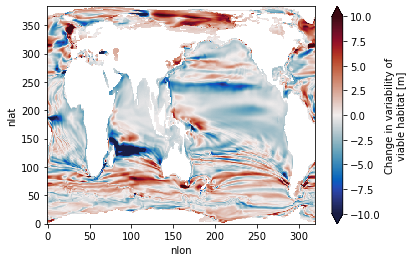

In [52]:
import cmocean

habitat_var_change.plot(vmin=-10, vmax=10, cmap=cmocean.cm.balance)

In [58]:
dso = xr.Dataset(
    dict(
        aero_hab_glb=aero_hab_glb,
        aero_hab_glb_normalized=aero_hab_glb_normalized,
        habitat_change=habitat_change,
        habitat_var_change=habitat_var_change,
    )
)

dso

<xarray.Dataset>
Dimensions:                  (member_id: 32, time: 181, nlat: 384, nlon: 320)
Coordinates:
  * member_id                (member_id) int64 2 9 10 11 12 ... 102 103 104 105
  * time                     (time) int64 1920 1921 1922 1923 ... 2098 2099 2100
    TLAT                     (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
    TLONG                    (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    KMT                      (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TAREA                    (nlat, nlon) float64 1.125e+13 ... 7.432e+12
    epoch                    <U12 'ref_climate'
Dimensions without coordinates: nlat, nlon
Data variables:
    aero_hab_glb             (time, member_id) float64 86.58 86.58 ... 78.58
    aero_hab_glb_normalized  (time, member_id) float64 0.1229 0.1243 ... -9.123
    habitat_change           (nlat, nlon) float64 nan nan nan ... nan nan nan
    habitat_var_change       (nlat, nlon) float64 nan nan nan ... nan nan nan

In [ ]:
this_notebook = 'compute-aerobic-habitat-change.ipynb'

curator = util.curator_local_assets()

key = 'aerobic-habitat-change'

cache_file = f'{dc.cache_dir}/{key}.zarr'
os.makedirs(os.path.dirname(cache_file), exist_ok=True)

dso.to_zarr(cache_file, mode='w', consolidated=True)

curator.add_source(
    key=key,
    urlpath=cache_file,
    description=f"""
    Change in aerobic habitat computed using trait-frequency weighting.
    Notebook: {this_notebook}
    """,
    driver='zarr',
    overwrite=True,
)

In [63]:
if clusted_scale:
    del client
    del cluster